Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [21]:
import category_encoders as cat
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer

In [3]:
import pandas as pd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

# Merge train_features.csv & train_labels.csv
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
df_test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', index_col='id')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [7]:
def wrangle(df):
    df = df.copy()
    
    date_recorded = pd.to_datetime(df['date_recorded'])
    
    df['month_recorded'] = date_recorded.dt.month
    df['year_recorded'] = date_recorded.dt.year
    
    ### recorded_by has only 1 unique, so no information
    ### subvillage and wpt_name are VERY high cardinality
    ### permit is least related to the target, as determined by chi2 tests
    
    df = df.drop(columns=['recorded_by', 'subvillage', 'wpt_name', 'permit'])
            
    return df

def CountImputer(df):
    for col in range(df.shape[1]):
        df[:, col] = np.nan_to_num(df[:, col], nan=np.count_nonzero(np.isnan(df[:, col])))
    return df

In [6]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

X = wrangle(X)

In [10]:
num_feats = X.select_dtypes('number').columns
cat_feats = X.select_dtypes('object').columns
cat_feats_low_card = [f for f in cat_feats if X[f].nunique() < 100]
cat_feats_high_card = [f for f in cat_feats if X[f].nunique() >= 100]

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

In [12]:
### THE GREAT TRANSFORMER

### This is a tree of its own sort, using FeatureUnions, Pipelines, 
### and ColumnTransformers to split the set by certain categories, 
### perform different encodings, and re-merge.

transformers = FeatureUnion([ 
    ('pca_part', Pipeline([              ## This section OneHot encodes low card columns, Count encodes
        ('encoders_for_pca',             ## both low and high card columns, and performs PCA on the aggregate
         ColumnTransformer([             ## keeping only the first principal component
            ('low_card', FeatureUnion([
                ('onehotencoder', cat.OneHotEncoder(use_cat_names=True)),
                ('countencoder', cat.CountEncoder(min_group_size=.1))
            ]), cat_feats_low_card),
            ('high_card', cat.CountEncoder(min_group_size=.1), cat_feats_high_card)
        ], verbose=True)),
        ('realimputer',
         FunctionTransformer(CountImputer)),
        ('standardscaler', 
         StandardScaler()),
        ('pca', 
         PCA(n_components=1))
    ])),
    ('ordinal_pipe',
     ColumnTransformer([                                           ## This section corresponds to the basic
         ('ordinalencoder', cat.OrdinalEncoder(), cat_feats),      ## ordinal encoding
         ('dumb', FunctionTransformer(lambda df: df), num_feats)
     ]))
])

In [13]:
transformers.fit(X_train)

c:\users\benjs\opencv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[ColumnTransformer] ...... (1 of 2) Processing low_card, total=   3.3s
[ColumnTransformer] ..... (2 of 2) Processing high_card, total=   0.1s


FeatureUnion(transformer_list=[('pca_part',
                                Pipeline(steps=[('encoders_for_pca',
                                                 ColumnTransformer(transformers=[('low_card',
                                                                                  FeatureUnion(transformer_list=[('onehotencoder',
                                                                                                                  OneHotEncoder(use_cat_names=True)),
                                                                                                                 ('countencoder',
                                                                                                                  CountEncoder(combine_min_nan_groups=True,
                                                                                                                               min_group_size=0.1))]),
                                                                           

In [14]:
XT_train = pd.DataFrame(transformers.transform(X_train), index=X_train.index)
XT_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454,-3.525501,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,2092.0,35.426020,-4.227446,0.0,21.0,1.0,160.0,1998.0,2.0,2013.0
510,4.126119,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,35.510074,-5.724555,0.0,1.0,6.0,0.0,0.0,3.0,2011.0
14146,3.747274,3.0,3.0,3.0,2.0,3.0,3.0,3.0,1.0,2.0,1.0,3.0,3.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,3.0,0.0,0.0,32.499866,-9.081222,0.0,12.0,6.0,0.0,0.0,7.0,2011.0
47410,-4.919457,4.0,4.0,4.0,3.0,3.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,1.0,1.0,0.0,0.0,34.060484,-8.830208,0.0,12.0,7.0,0.0,0.0,4.0,2011.0
1288,5.603170,5.0,5.0,5.0,4.0,4.0,5.0,5.0,1.0,2.0,1.0,3.0,3.0,3.0,2.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,3.0,300.0,1023.0,37.032690,-6.040787,0.0,5.0,1.0,120.0,1997.0,4.0,2011.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68525,-5.228989,194.0,43.0,6.0,3.0,4.0,57.0,354.0,1.0,1.0,182.0,1.0,1.0,1.0,3.0,1.0,3.0,3.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0,1000.0,327.0,36.367112,-8.774761,0.0,5.0,4.0,255.0,1995.0,3.0,2011.0
11980,-4.515611,158.0,11.0,41.0,8.0,9.0,35.0,625.0,1.0,2.0,13.0,1.0,1.0,1.0,2.0,1.0,6.0,6.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1000.0,1743.0,34.531524,-9.769604,0.0,11.0,5.0,35.0,1988.0,3.0,2011.0
35778,4.364054,24.0,1699.0,1924.0,7.0,8.0,95.0,688.0,2.0,9.0,1.0,3.0,3.0,3.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,-13.0,38.974416,-5.420823,0.0,4.0,5.0,1000.0,2005.0,3.0,2011.0


In [15]:
XT_val = pd.DataFrame(transformers.transform(X_val), index=X_val.index)

In [17]:
model = RandomForestClassifier(n_estimators=1200, 
                               random_state=42, 
                               n_jobs=-1, 
                               max_depth=30, 
                               max_leaf_nodes=4500,
                               min_samples_leaf=2,
                               min_samples_split=3)

In [18]:
model.fit(XT_train, y_train)

RandomForestClassifier(max_depth=30, max_leaf_nodes=4500, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=1200, n_jobs=-1,
                       random_state=42)

In [28]:
model.score(XT_val, y_val)

0.8148148148148148

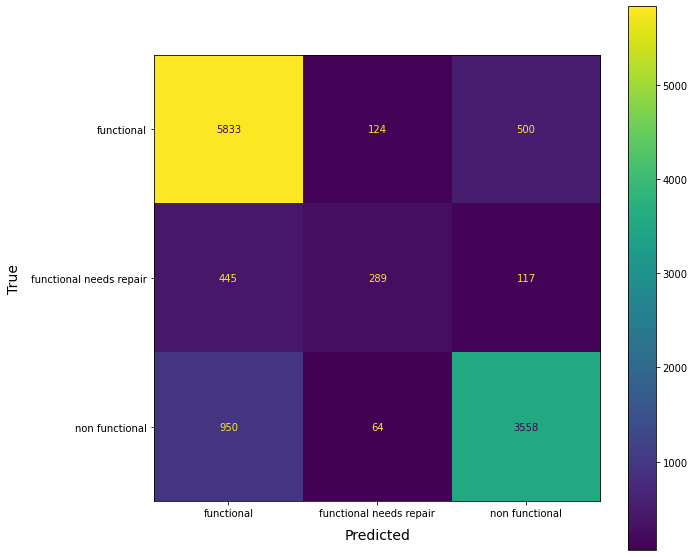

In [32]:
fig, ax = plt.subplots(figsize=[10,10])

plot_confusion_matrix(model, XT_val, y_val, ax=ax)
ax.set_xlabel('Predicted', labelpad=10, fontsize=14)
ax.set_ylabel('True', labelpad=10, fontsize=14)

plt.show()